In [1]:
!pip install -Uq setuptools wheel pip

In [2]:
!pip install -Uq transformers peft torch
!pip install -q einops flash_attn timm

In [3]:
!pip install -Uq jupyter ipywidgets matplotlib pandas scipy tabulate

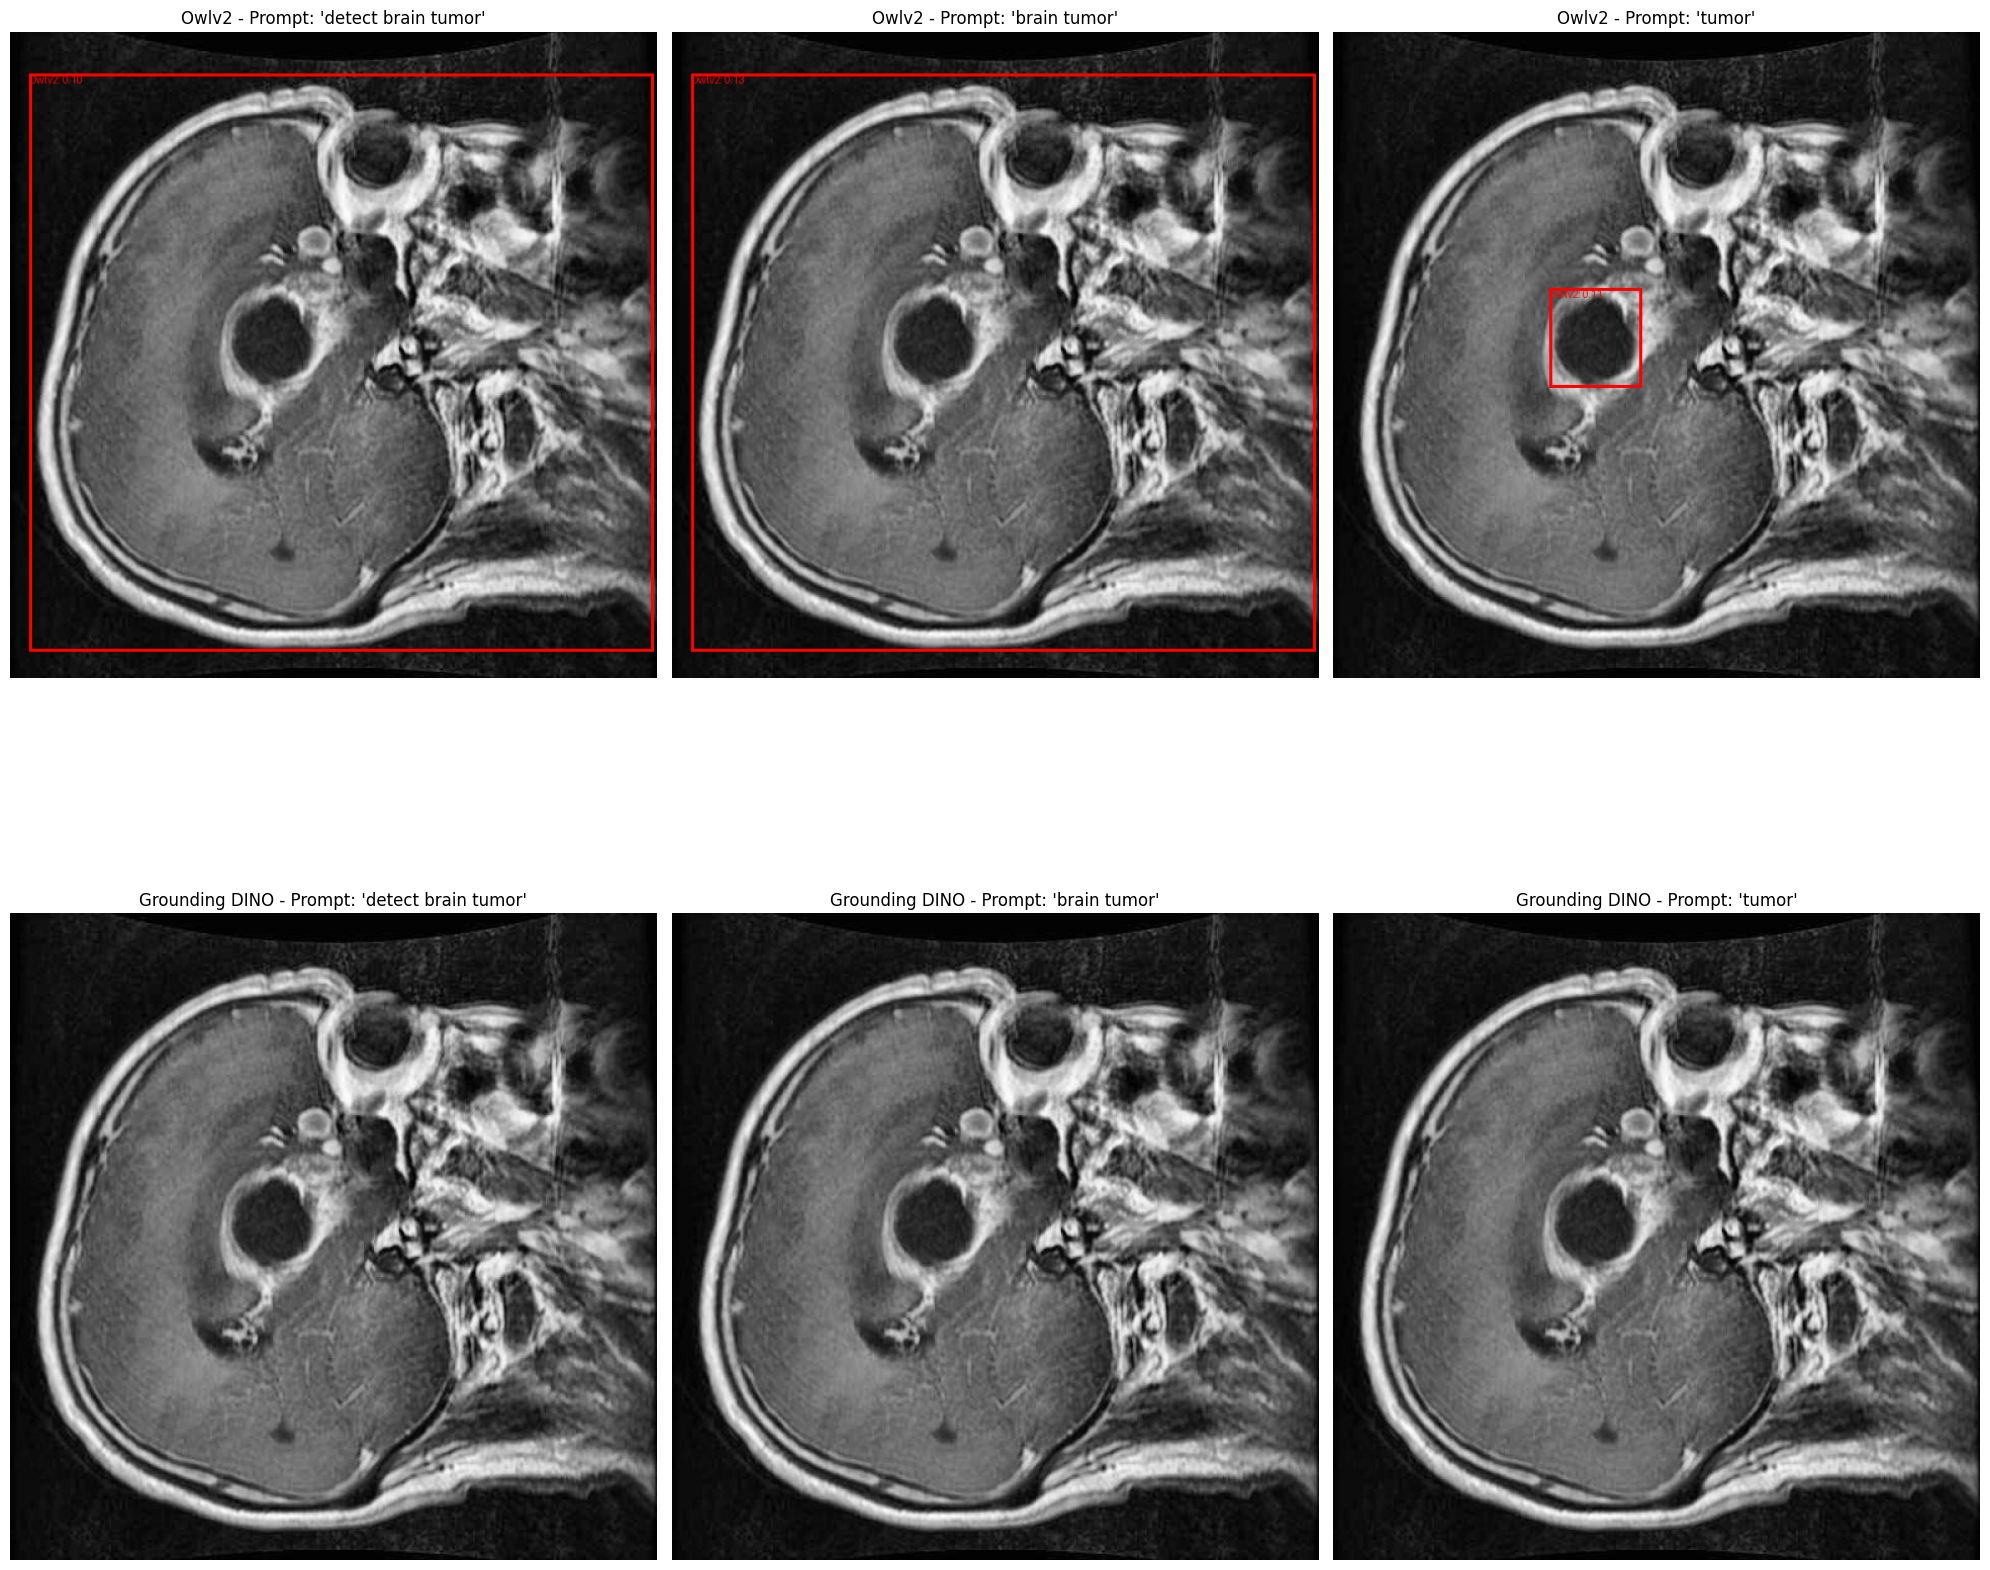

In [4]:
import torch
from transformers import (
    Owlv2Processor, Owlv2ForObjectDetection,
    AutoProcessor, AutoModelForZeroShotObjectDetection
)
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import pandas as pd
from tabulate import tabulate

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float32

def load_image(image_path_or_url):
    try:
        if image_path_or_url.startswith(('http://', 'https://')):
            response = requests.get(image_path_or_url)
            response.raise_for_status()
            return Image.open(BytesIO(response.content))
        else:
            return Image.open(image_path_or_url)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

def process_image_owlv2(processor, model, image, prompt):
    inputs = processor(text=[prompt], images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    
    # Ensure the target_sizes are in float32
    target_sizes = torch.tensor([image.size[::-1]], dtype=torch.float32).to(device)
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]
    return results

def process_image_grounding_dino(processor, model, image, prompt):
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Ensure the target_sizes are in float32
    target_sizes = torch.tensor([image.size[::-1]], dtype=torch.float32).to(device)
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.4,
        text_threshold=0.3,
        target_sizes=target_sizes
    )[0]
    return results

def draw_bounding_boxes(image, results, prompt, model_name):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{model_name}: {score:.2f}", fill="red", font=font)

    return image

def visualize_results(image_path_or_url, models, prompts):
    original_image = load_image(image_path_or_url)
    if original_image is None:
        print("Failed to load the image. Please check the image path or URL.")
        return

    fig, axs = plt.subplots(len(models), len(prompts), figsize=(20, 20))

    results_data = []

    for i, (model_name, (model, processor)) in enumerate(models.items()):
        for j, prompt in enumerate(prompts):
            if model_name == "Owlv2":
                results = process_image_owlv2(processor, model, original_image, prompt)
            elif model_name == "Grounding DINO":
                results = process_image_grounding_dino(processor, model, original_image, prompt)

            image_with_boxes = draw_bounding_boxes(original_image.copy(), results, prompt, model_name)

            axs[i, j].imshow(image_with_boxes)
            axs[i, j].set_title(f"{model_name} - Prompt: '{prompt}'")
            axs[i, j].axis('off')

            if len(results["scores"]) > 0:
                for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                    results_data.append({
                        "Model": model_name,
                        "Prompt": prompt,
                        "Confidence": score.item(),
                        "Box": box.tolist()
                    })
            else:
                results_data.append({
                    "Model": model_name,
                    "Prompt": prompt,
                    "Confidence": 0.0,
                    "Box": "No object detected"
                })

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results_data)

# Load models and processors onto the GPU
models = {
    "Owlv2": (
        Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble", torch_dtype=torch_dtype).to(device),
        Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
    ),
    "Grounding DINO": (
        AutoModelForZeroShotObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base", torch_dtype=torch_dtype).to(device),
        AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")
    )
}

# Define image path or URL and prompts
image_path_or_url = "https://huggingface.co/spaces/dwb2023/omniscience/resolve/main/examples/2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg"
prompts = ["detect brain tumor", "brain tumor", "tumor"]

# Visualize results and get DataFrame
results_df = visualize_results(image_path_or_url, models, prompts)

In [5]:
# print results_df as a table
# increase width of the table
pd.set_option('display.width', 4000)  # Increase overall display width
pd.set_option('display.max_colwidth', None)
display(results_df)

,Model,Prompt,Confidence,Box
0,Owlv2,detect brain tumor,0.103667,"[19.019737243652344, 41.69416427612305, 635.8213500976562, 612.522216796875]"
1,Owlv2,brain tumor,0.125494,"[19.019737243652344, 41.69416427612305, 635.8213500976562, 612.522216796875]"
2,Owlv2,tumor,0.105753,"[213.55923461914062, 253.6807098388672, 304.7489929199219, 351.94683837890625]"
3,Grounding DINO,detect brain tumor,0.000000,No object detected
4,Grounding DINO,brain tumor,0.000000,No object detected
5,Grounding DINO,tumor,0.000000,No object detected
